<a href="https://colab.research.google.com/github/paneri11/PBL-Project/blob/main/PBL_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [ ]:
dataset_path = "/content/drive/MyDrive/RAVDESS /RAVDESS Dataset"

In [ ]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [ ]:
def parse_ravdess_filename(filename):
    parts = filename.split('-')
    try:
        emotion = emotion_map.get(parts[2])
        actor = int(parts[-1].split('.')[0])
        return emotion, actor
    except:
        return None, None

# Collect file paths and labels
filepaths, emotions = [], []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            emotion, actor = parse_ravdess_filename(file)
            if emotion:
                filepaths.append(os.path.join(root, file))
                emotions.append(emotion)

df = pd.DataFrame({"filepath": filepaths, "emotion": emotions})

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])

In [ ]:
def extract_modified_fft(audio, sr, bins=173):
    fft = np.fft.fft(audio)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    # Custom emotion-weighting kernel (amplify 300–3400Hz range)
    freqs = np.fft.fftfreq(len(magnitude), 1/sr)
    weights = np.where((freqs > 300) & (freqs < 3400), 1.5, 0.5)
    weighted_mag = magnitude * weights[:len(magnitude)]
    # Return binned features (truncate/pad to fixed size)
    return np.pad(weighted_mag[:bins], (0, max(0, bins - len(weighted_mag[:bins]))), mode='constant')

In [ ]:
def extract_features(file_path, sr=22050, n_mfcc=40, max_len=173):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=4.0)
        audio = librosa.util.fix_length(audio, size=sr*4)

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        mfft = extract_modified_fft(audio, sr=sr, bins=max_len)

        return mfcc, mfft
    except:
        return np.zeros((n_mfcc, max_len)), np.zeros(max_len)

In [ ]:
# Extract features
mfcc_features = []
fourier_features = []
y = []

for idx in tqdm(range(len(df))):
    mfcc, mfft = extract_features(df.iloc[idx]['filepath'])
    mfcc_features.append(mfcc)
    fourier_features.append(mfft)
    y.append(df.iloc[idx]['label'])

X_mfcc = np.array(mfcc_features)[..., np.newaxis]  # (samples, 40, 173, 1)
X_fft = np.array(fourier_features)  # (samples, 173)

y = np.array(y)

100%|██████████| 2880/2880 [18:08<00:00,  2.65it/s]


In [ ]:
X_flat = X_mfcc.reshape(X_mfcc.shape[0], -1)
X_combined = np.concatenate([X_flat, X_fft], axis=1)

In [ ]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y)

In [ ]:
X_res = X_res[:, :6920]  # 40*173 = 6920 for MFCC
X_fft_res = X_res[:, 6920:]
X_mfcc_res = X_res[:, :6920].reshape(-1, 40, 173, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
# Build CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 173, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 171, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 85, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 83, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 41, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 41, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,687,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,707,336 (10.33 MB)

 Trainable params: 2,707,144 (10.33 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Train
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=50, batch_size=32)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.1802 - loss: 4.0224 - val_accuracy: 0.2862 - val_loss: 1.8641
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.3278 - loss: 1.8211 - val_accuracy: 0.4211 - val_loss: 1.5788
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 336ms/step - accuracy: 0.3900 - loss: 1.5958 - val_accuracy: 0.4065 - val_loss: 1.5629
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - accuracy: 0.4643 - loss: 1.4205 - val_accuracy: 0.5805 - val_loss: 1.1999
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.5410 - loss: 1.1847 - val_accuracy: 0.6911 - val_loss: 0.9900
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step - accuracy: 0.6072 - loss: 1.0316 - val_accuracy: 0.7041 - val_loss: 0.8636
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 338ms/step - accuracy: 0.6664 - loss: 0.8556 - val_accuracy: 0.7415 - val_loss: 0.7077
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 327ms/step - accuracy: 0.7132 - loss: 0.7285 - val_accu

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step
              precision    recall  f1-score   support

       angry       0.95      0.95      0.95        77
        calm       0.95      0.92      0.93        76
     disgust       0.97      1.00      0.99        77
     fearful       0.95      1.00      0.97        77
       happy       0.92      0.87      0.89        77
     neutral       1.00      1.00      1.00        77
         sad       0.85      0.87      0.86        77
   surprised       0.97      0.95      0.96        77

    accuracy                           0.94       615
   macro avg       0.94      0.94      0.94       615
weighted avg       0.94      0.94      0.94       615



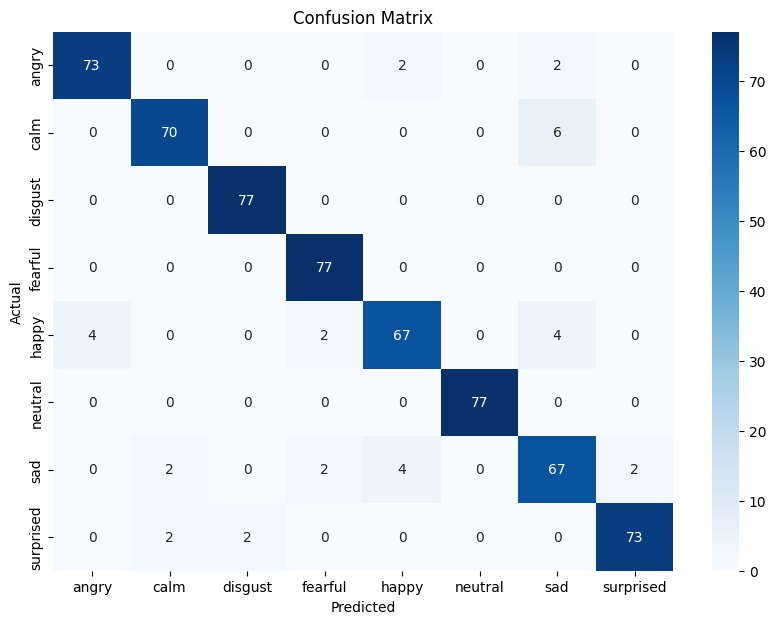

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save model and label encoder
model.save("emotion_cnn_model_with_mft.h5")
import joblib
joblib.dump(le, "emotion_label_encoder.pkl")

['emotion_label_encoder.pkl']

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9447154471544715
